Iterated Fit:
 [1.09687423e+00 1.17341010e+02 2.00911771e+03] 
 [[ 2.12079786e-02  9.27264678e-03 -1.60283056e+00]
 [ 9.27264678e-03  7.43478915e-01 -1.31555064e+01]
 [-1.60283056e+00 -1.31555064e+01  4.76812444e+02]]
Weighted Lsq Fit:
 86.12341768836083 3167.098223105604
Lsq Fit:
 33.482087983073285 4435.390730234245
The estimated Background 0.7


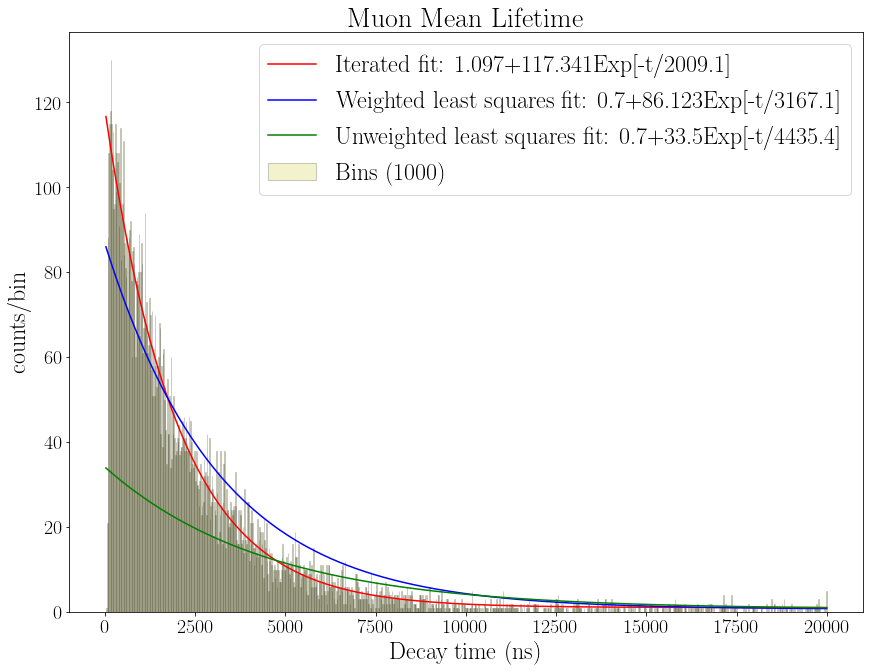

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
from numpy import loadtxt
import matplotlib
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def exponentialfit(x, y):
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = 1
    n = len(x)
    sxlny = sum(x*np.log(y))
    slny = sum(np.log(y))
    sx2 = sum(x**2)
    sx = sum(x)
    return np.exp((slny*sx2 - sx*sxlny)/(n*sx2 - sx**2)),\
            (n*sxlny - sx*slny)/(n*sx2 - sx**2)

def exponentialweightedfit(x, y):
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = 1
    n = len(x)
    sxlny = sum(x*np.log(y))
    sx2y = sum((x**2)*y)
    sxy = sum(x*y)
    slny = sum(np.log(y))
    sx2 = sum(x**2)
    sx = sum(x)
    sy = sum(y)
    sylny = sum(y*np.log(y))
    sxylny = sum(x*y*np.log(y))
    return np.exp((sx2y*sylny - sxy*sxylny)/(sy*sx2y-sxy**2)),\
                   (-(sxy*sylny)+sy*sxylny)/(sy*sx2y - (sxy**2));

data = loadtxt('unsifted.dat',unpack=True, usecols=[0])
data = [x for x in data if x < 39999]

binsc = np.arange(20,20020,20)
y, bins = np.histogram(data, bins = binsc)
x = (bins[1:]+bins[:-1])/2
x2 = np.delete(x, [0,1,2,3,4,5,6,7,8])#delete bad bins###########
y2 = np.delete(y, [0,1,2,3,4,5,6,7,8])
        
#calc background
num = 30
cc = 0.0
for j in range(len(y2)-num,len(y2)):
    cc = cc + y2[j]
cc = cc/num

a = exponentialfit(x2,y2)
b = exponentialweightedfit(x2,y2)

#iterated
def func(x, c, a, b):
    return c + a * np.exp(-x/b)

init_vals = [cc, b[0], -1/b[1]] 
popt, pcov = curve_fit(func, x2, y2, p0=init_vals)

print("Iterated Fit:\n",popt,"\n",pcov)
print("Weighted Lsq Fit:\n",b[0],-1/b[1])
print("Lsq Fit:\n",a[0],-1/a[1])
print("The estimated Background",cc)

plt.figure()
plt.plot(x, func(x,*popt), 
         label='Iterated fit: %1.3f+%1.3fExp[-t/%1.1f]' % (popt[0],popt[1],popt[2]), color='red')
plt.plot(x,func(x,cc,b[0],-1/b[1]), color='blue',
         label='Weighted least squares fit: %1.1f+%1.3fExp[-t/%1.1f]' % (cc,b[0],-1/b[1]))
plt.plot(x,func(x,cc,a[0],-1/a[1]), color='green',
         label='Unweighted least squares fit: %1.1f+%1.1fExp[-t/%1.1f]' % (cc,a[0],-1/a[1]))
plt.hist(data, bins=binsc,color = "y", alpha= .2, ec="black",label='Bins (%i)' % len(binsc))
plt.xlabel('Decay time (ns)', fontsize=24)
plt.ylabel('counts/bin', fontsize=24)
plt.title('Muon Mean Lifetime', fontsize=28)
plt.legend(loc=0,prop={'size':24})
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(1024.0/float(DPI),768.0/float(DPI))
plt.savefig('muonpy.pdf')
plt.close( 'muonpy.pdf')

-1.724311181305893e-05 -1715.7678738095606 3353.816520911865


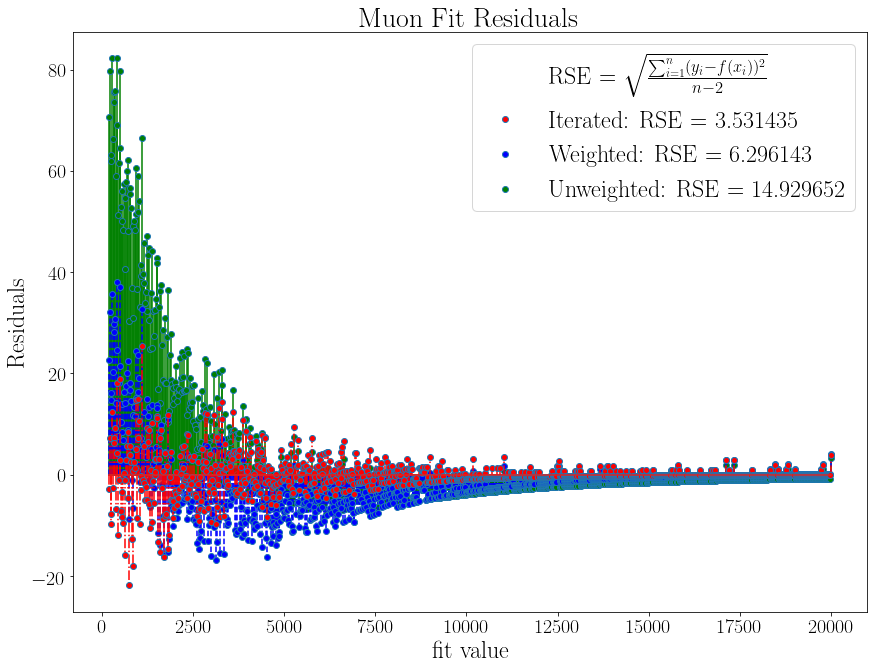

In [3]:
y3 = y2-(popt[0]+popt[1]*np.exp(-x2/popt[2]))
y4 = y2-(cc+b[0]*np.exp(b[1]*x2))
y5 = y2-(cc+cc+a[0]*np.exp(a[1]*x2))
print(sum(y3),sum(y4),sum(y5))
rsenlm = np.sqrt(sum(y3**2)/(len(y2) - 2))
rsewlsq = np.sqrt(sum(y4**2)/(len(y2) - 2))
rselsq = np.sqrt(sum(y5**2)/(len(y2) - 2))


fig, ax = plt.subplots()
markerline2, stemlines, _ = plt.stem(x2, y5, '-', linefmt='g')
h1 = plt.setp(markerline2, 'markerfacecolor', 'g', label='Unweighted: RSE = %f' % rselsq)
markerline2, stemlines, _ = plt.stem(x2, y4,linefmt='--b')
h2 = plt.setp(markerline2, 'markerfacecolor', 'b', label='Weighted: RSE = %f' % rsewlsq)

markerline1, stemlines, _ = plt.stem(x2, y3, linefmt= '-.''r')
h3 = plt.setp(markerline1, 'markerfacecolor','r', label='Iterated: RSE = %f' % rsenlm)
h4 = plt.plot([], [], ' ', label="RSE = $\\sqrt{\\frac{\\sum^n_{i=1}(y_i-f(x_i))^2}{n-2}}$")

plt.xlabel('fit value', fontsize=24)
plt.ylabel('Residuals', fontsize=24)
plt.title('Muon Fit Residuals', fontsize=28)

handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[3],handles[2],handles[1],handles[0]], 
           [labels[3],labels[2],labels[1],labels[0]],
           loc=0,prop={'size':24})
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(1024.0/float(DPI),768.0/float(DPI))
plt.savefig('muonpyres.pdf')
plt.close( 'muonpyres.pdf')

In [9]:
PI = 3.14159265358979323846264338327950288
initelement = 0
n_sets = 40
setsize = 50
bins2 = 9
data = loadtxt('unsifted.dat',unpack=True, usecols=[0])
data = [x for x in data if x < 39999]
groupall = []
a = []
b = []
for i in range(n_sets):
    groupall.append([])
    a.append([])
for i in range(n_sets):
    for j in range(setsize):
        groupall[i].append(data[j+initelement+i*setsize])
        if groupall[i][j] < popt[2]:
            a[i].append(groupall[i][j])
    b.append(len(a[i]))
y, bins = np.histogram(b, bins = binsc)


# calculate mean
mean = sum(b) / len(b)
# calculate variance using a list comprehension
var_res = sum((xi - mean) ** 2 for xi in b) / (len(b)-1)
sdom = np.sqrt(var_res)
print (mean , var_res, sdom)

28.675 11.199358974358974 3.346544333242722


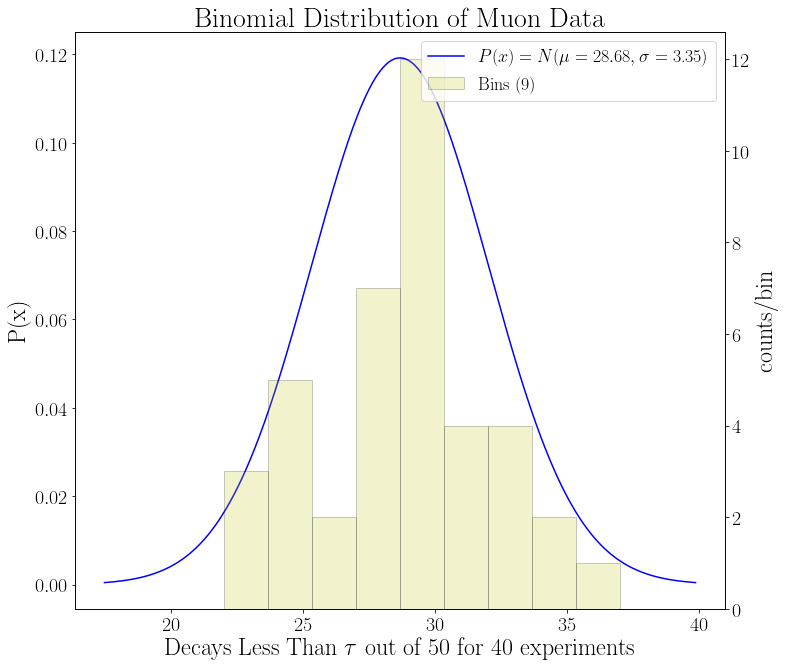

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# label = '$P(x) = \\frac{1}{{\\sigma \\sqrt {2\\pi } }}e^{{{ - \\left( {x - \\mu } \\right)^2 } \\mathord{\\left/ {\\vphantom {{ - \\left( {x - \\mu } \\right)^2 } {2\\sigma ^2 }}} \\right. \\kern-\\nulldelimiterspace} {2\\sigma ^2 }}}$'
label = '$P(x) = N(\\mu =%1.2f,  \\sigma$ = %1.2f)' % (mean, sdom)

xplot = np.linspace(mean-var_res,mean+var_res,1000)

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('Decays Less Than $\\tau$ out of 50 for 40 experiments', fontsize=24)
ax1.set_ylabel('P(x)', color=color, fontsize=24)
ax1.plot(xplot,(1/(sdom*np.sqrt(2.0*PI)))*np.exp(-(((xplot-mean)*(xplot-mean))/(2.0*var_res))), 
         color='blue',label=label)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.legend(loc=1,prop={'size':20})

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('counts/bin', color=color, fontsize=24)  # we already handled the x-label with ax1
ax2.hist(b, bins=bins2,color = "y", alpha= .2, ec="black",label='Bins (%i)' % bins2)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, prop={'size':18})
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Binomial Distribution of Muon Data', fontsize=28)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(1024.0/float(DPI),768.0/float(DPI))
plt.savefig('muonpy2.pdf')
plt.close( 'muonpy2.pdf')
plt.show()

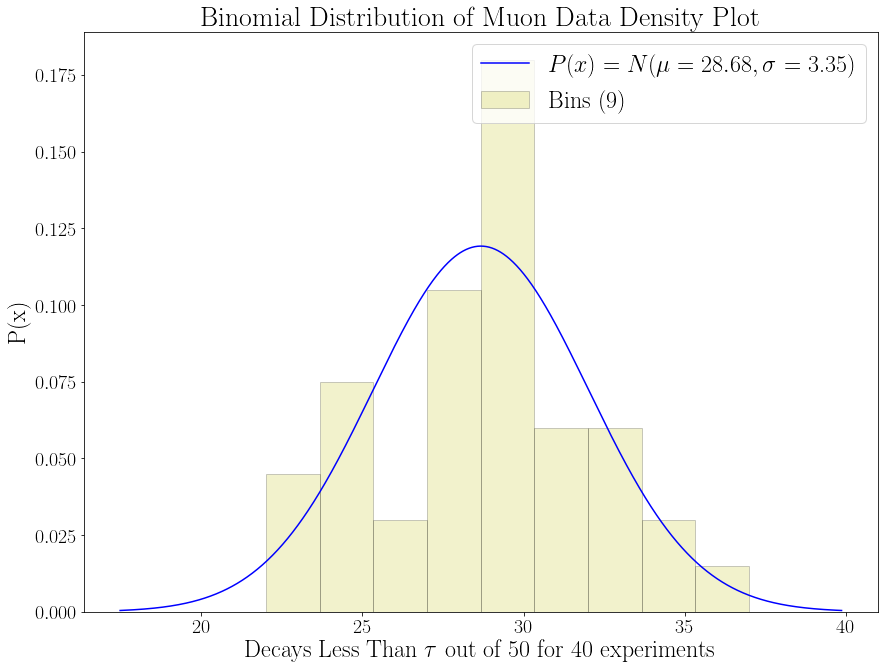

In [26]:
import numpy as np
import matplotlib.pyplot as plt
label = '$P(x) = N(\\mu =%1.2f,  \\sigma$ = %1.2f)' % (mean, sdom)
xplot = np.linspace(mean-var_res,mean+var_res,1000)

plt.figure()
plt.plot(xplot,(1/(sdom*np.sqrt(2.0*PI)))
         *np.exp(-(((xplot-mean)*(xplot-mean))/(2.0*var_res))), 
         color='blue',label=label)
plt.hist(b, bins=bins2,density = True, color = "y", alpha= .2, ec="black",label='Bins (%i)' % bins2)

plt.xlabel('Decays Less Than $\\tau$ out of 50 for 40 experiments', fontsize=24)
plt.ylabel('P(x)', fontsize=24)
plt.title('Binomial Distribution of Muon Data Density Plot', fontsize=28)
plt.legend(loc=0,prop={'size':24})
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(1024.0/float(DPI),768.0/float(DPI))
plt.savefig('muonpy3.pdf')
plt.close( 'muonpy3.pdf')